# 方向梯度直方图

### 在HOG特征描述符中，梯度方向（定向梯度）的分布（直方图）被用作特征。图像的梯度（x和y导数）是有用的，因为在边缘和角落（突然强度变化的区域）周围的梯度幅度很大，并且我们知道边缘和角落包含关于物体形状的更多信息而不是平坦区域。

In [2]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt

In [3]:
img = cv2.imread("lena_std.tif")
gray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #转化成灰度图像
im = np.float32(img) / 255.0 #对像素做归一化处理

In [80]:
# 生成x和y两个方向的Sobel算子
gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=1)
mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True) #使用Sobel算子提取边缘后计算梯度的幅值g和方向theta
plt.imshow(np.uint8(mag)) #

### 在每个像素处，梯度具有幅度和方向。对于彩色图像，评估三个通道的梯度。一个像素处的梯度的大小是三个通道的梯度的最大值，并且角度是对应于最大梯度的角度。

In [173]:
#产生两个空矩阵，用以存放梯度最大值角度和梯度值
max_gradition = np.zeros((512,512)) 
max_graditiontoangle = np.zeros((512,512))
dict_bin = {} #设置字典，将统计的梯度角度和梯度值对应
for i in range(512):
    for j in range(512):
        max_gradition[i, j] = int(max(mag[i, j])) #返回最大值赋值给最大梯度矩阵
        ind = mag[i, j].tolist().index(max(mag[i, j])) #返回其最大值的索引，即最大值对应的通道
        if angle[i, j][ind] > 180:
            max_graditiontoangle[i, j] = int(angle[i, j][ind] -180) #大于180° 则减去180°
            angle_new = int(angle[i, j][ind] -180)               
        else:
            angle_new = int(angle[i, j][ind])
        (x,y) = divmod(angle_new, 20) #用角度除以20度，划分区间，商为x,余数为y,x决定了bin的区间
        if x < 8:
            x = x*20 #将商值*20转化为角度区间
            if y/20 < 0.5:
                dict_bin[x] = dict_bin.get(x,0) + int(max(mag[i, j]))
            elif y/20 >0.5:
                dict_bin[x+20] = dict_bin.get(x+20,0) + int(max(mag[i, j]))
            else: #余数处于20中间的，将梯度值平分到两个梯度角度区间
                dict_bin[x] = dict_bin.get(x,0) + int(max(mag[i, j]))/2
                dict_bin[x+20] = dict_bin.get(x+20,0) + int(max(mag[i, j]))/2
        if x == 8: #当大于160度时
            x = x*20
            if y/20 < 0.5:
                dict_bin[x] = dict_bin.get(x,0) + int(max(mag[i, j]))
            elif y/20 >0.5:
                dict_bin[0] = dict_bin.get(0,0) + int(max(mag[i, j]))
            else: 
                dict_bin[x] = dict_bin.get(x,0) + int(max(mag[i, j]))/2 #小于170度的部分划分给160度区间
                dict_bin[0] = dict_bin.get(0,0) + int(max(mag[i, j]))/2 #大于170度的部分划分给0度区间

In [174]:
dict_bin_sort = sorted(dict_bin.items(), key = lambda x:x[0]) #对梯度字典按照角度从小到大排序

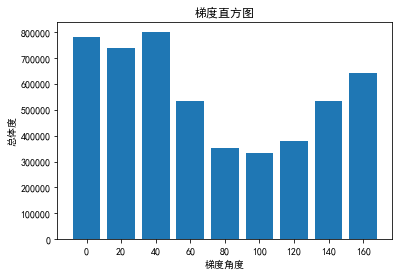

In [175]:
# 绘制梯度直方图

plt.rcParams['font.sans-serif']=['SimHei'] #设置能显示中文的字体
x_angle = [str(i[0]) for i in dict_bin_sort] #形成x轴坐标
y_mag = [i[1] for i in dict_bin_sort] #形成y轴坐标
plt.bar(x_angle, y_mag) #绘制条状图
plt.xlabel('梯度角度'), plt.ylabel('总体度'), plt.title('梯度直方图')
plt.show()